<a href="https://colab.research.google.com/github/pgdinamica/deeplearning/blob/main/notebooks/RedesConvolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neurais Convolucionais

As redes convolucionais ou redes de convolução têm sido aplicadas com muito sucesso em tarefas relacionadas a imagens. Nesta aula, entenderemos a ideia por trás deste tipo de arquitetura de rede neural e resolveremos um problema de classificação binária de imagens.


# Preparando o Conjunto de Dados

Vamos usar um conjunto de dados de imagens clássico chamado CIFAR10. 



In [2]:
import torch
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

In [3]:
BASE_DIR = '/datasets'
DATA_DIR = '/cifar10'
CATEGORIES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
def get_path(relpath):
  return os.path.join(BASE_DIR, relpath)

In [4]:
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

In [5]:
(len(cifar10_train), len(cifar10_test))

(50000, 10000)

## Vamos visualizar algumas imagens dos dados

In [6]:
def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(8, 8))
  rows, cols = 2, 2
  for i in range(1, 5):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(CATEGORIES[label])
      plt.axis("off")
      if istensor:
        plt.imshow(img.squeeze().permute(1, 2, 0))
      else:
        plt.imshow(img)
  plt.show()

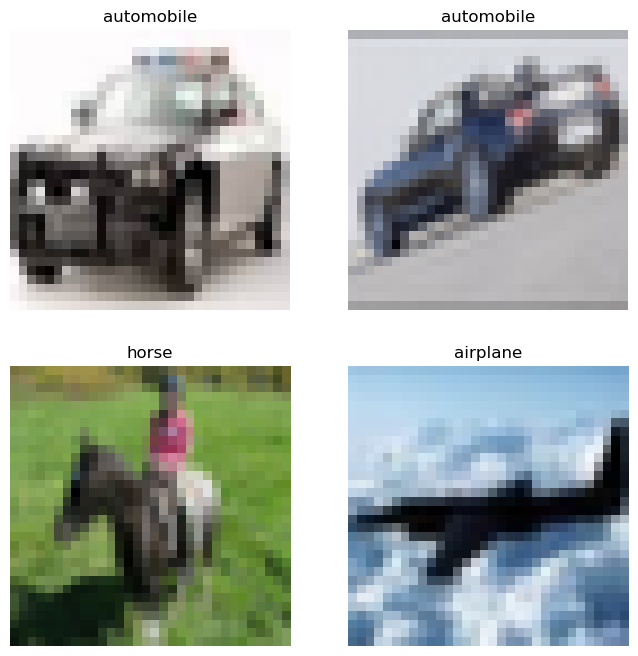

In [7]:
lookat_dataset(cifar10_train)

# Aplicando transformações e dividindo os dados

In [8]:
prep_transform = T.Compose([
                    T.ToTensor(),
                    T.Normalize(
                        (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
                    )
                  ])

# Applying a transform
tensor_train = CIFAR10(DATA_DIR, train=True, download=False,
                         transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False,
                         transform=prep_transform)


In [9]:
# Normalizing data
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [10]:
imgs.view(3, -1).mean(dim=1)

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [11]:
imgs.view(3, -1).std(dim=1)

tensor([1.0001, 0.9999, 1.0000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9259666..1.0796635].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4166123..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8192375..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0686196..2.0781739].


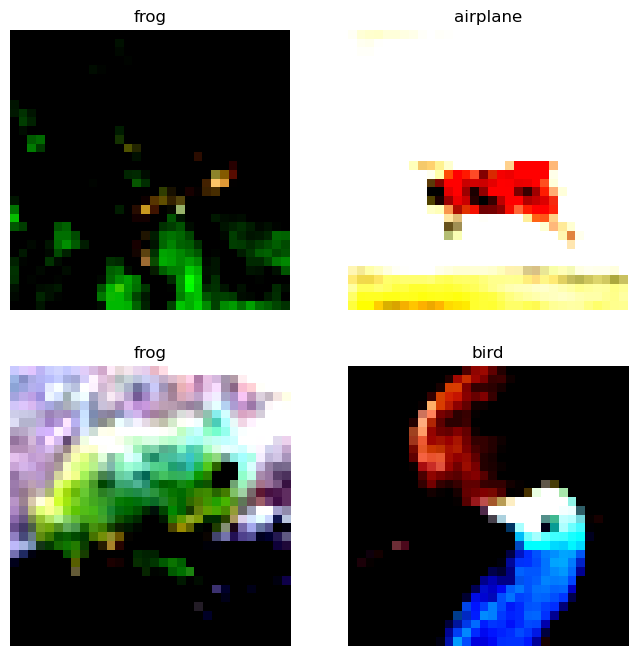

In [12]:
lookat_dataset(tensor_train, True)

## Criando DataLoaders

In [13]:
batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=False)

# Construindo uma rede MLP 

MLP = MultiLayer Perceptron (multi camadas de perceptrons)

In [14]:
from torch import nn

In [15]:
class MLPClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    
    self.layers = nn.Sequential(
        nn.Linear(3 * 32*32, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
    )

  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cpu


In [17]:
model = MLPClassifier().to(device)

## Escolhendo os hiperparâmetros de otimização

In [18]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [19]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    
    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(dataloader)

In [20]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

## Treinando a rede

In [21]:
epochs = 41
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(model, train_loader, loss_func, optimizer)
  train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  
  test_loss = validate(model, test_loader, loss_func)
  test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.2920058743118323
Epoch: 10; Train Loss: 1.836471657313959
Epoch: 20; Train Loss: 1.6290790809084996
Epoch: 30; Train Loss: 1.5038286208191796
Epoch: 40; Train Loss: 1.4000119723932212


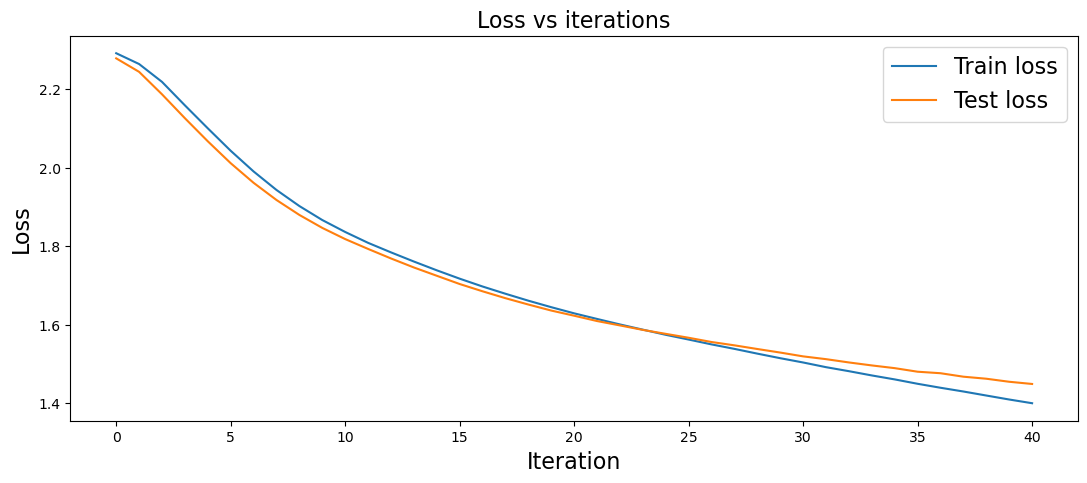

In [22]:
losses = {"Train loss": train_losses, "Test loss": test_losses}
plot_losses(losses)

# Avaliando o resultado

In [23]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1), 
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))



In [24]:
confusion_matrix = evaluate_accuracy(model, test_loader, CATEGORIES)

Accuracy for class airplane is: 52.7 %
Accuracy for class automobile is: 62.3 %
Accuracy for class bird  is: 34.0 %
Accuracy for class cat   is: 30.5 %
Accuracy for class deer  is: 32.9 %
Accuracy for class dog   is: 38.4 %
Accuracy for class frog  is: 60.1 %
Accuracy for class horse is: 57.1 %
Accuracy for class ship  is: 67.4 %
Accuracy for class truck is: 54.5 %
Global acccuracy is 49.0


In [25]:
import seaborn as sn

<Axes: >

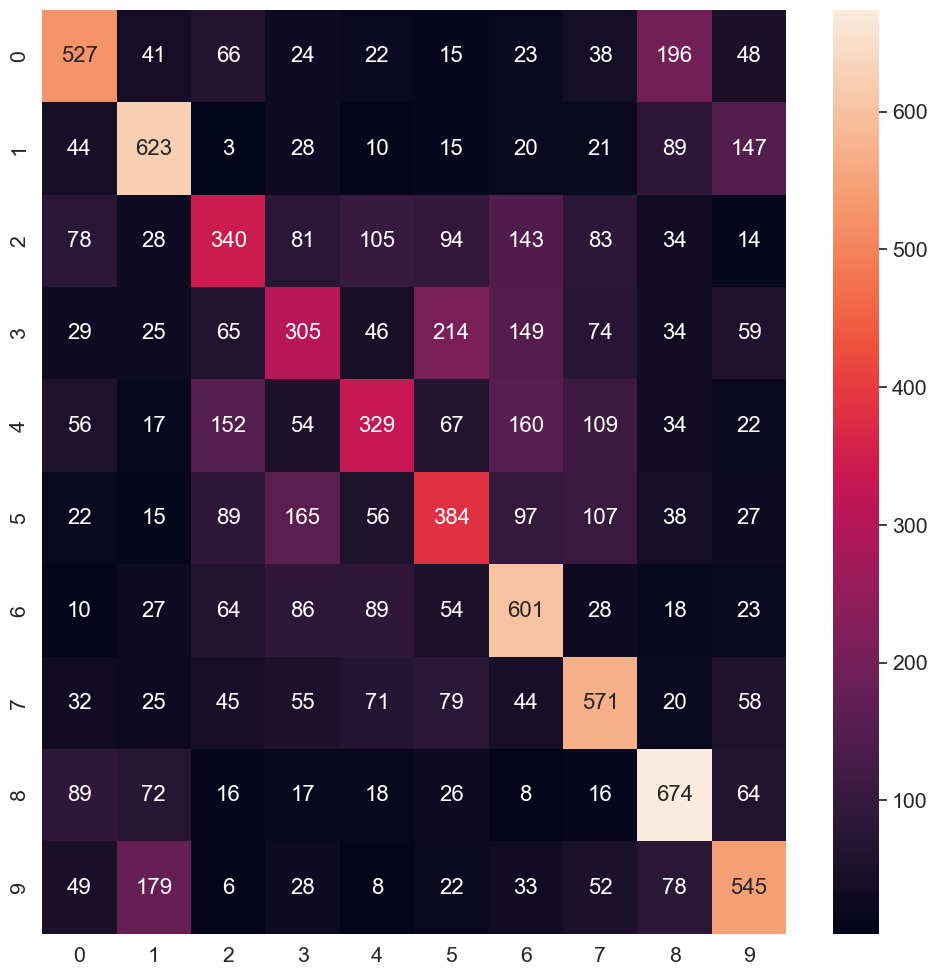

In [26]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d')

# Construindo uma rede neural de convolução

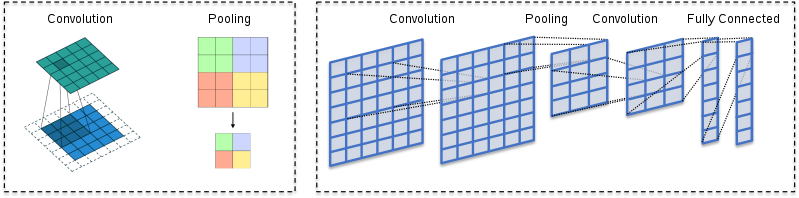

**Convoluções já eram usadas em imagens há muuuuuuito tempo.**

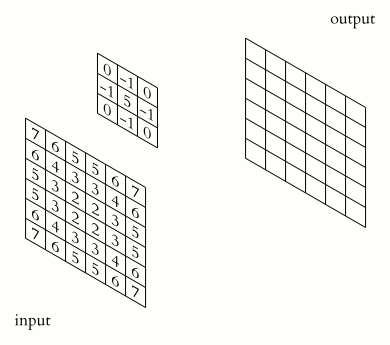

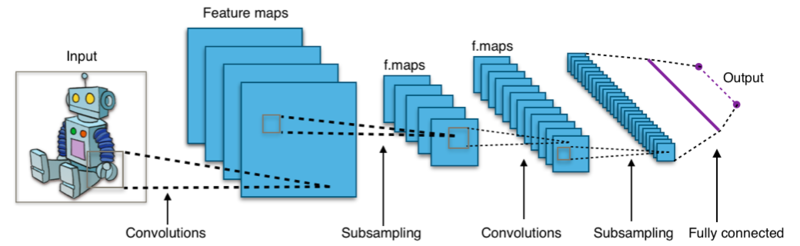

*Imagens de commons.wikimedia.org*

In [27]:
class ConvolutionalModel(nn.Module):
  def __init__(self):
      super().__init__()
      self.convlayers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(16, 32, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

      )

      self.linearlayers = nn.Sequential(
          nn.Linear(1152, 256),
          nn.ReLU(),
          nn.Linear(256, 10)
      )

  def forward(self, x):
      x = self.convlayers(x)
      x = torch.flatten(x, 1)
      return self.linearlayers(x)

In [28]:
convmodel = ConvolutionalModel().to(device)

In [29]:
loss_func2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(convmodel.parameters(), lr=0.001)

In [30]:
epochs = 51
conv_train_losses = []
conv_test_losses = []
for t in range(epochs):
  train_loss = train(convmodel, train_loader, loss_func2, optimizer2)
  conv_train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  test_loss = validate(convmodel, test_loader, loss_func2)
  conv_test_losses.append(test_loss)  

Epoch: 0; Train Loss: 2.2817781934957675
Epoch: 10; Train Loss: 1.7283593460422038
Epoch: 20; Train Loss: 1.463728968292246
Epoch: 30; Train Loss: 1.3236143162945653
Epoch: 40; Train Loss: 1.220954923678542
Epoch: 50; Train Loss: 1.133100824968894


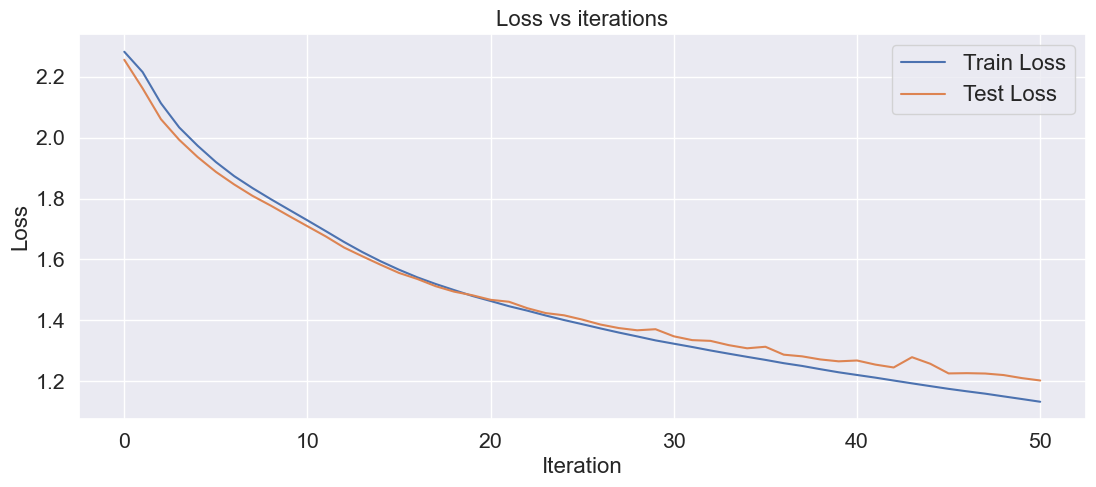

In [31]:
conv_losses = {"Train Loss": conv_train_losses, "Test Loss": conv_test_losses}
plot_losses(conv_losses)

In [32]:
conv_confusion_matrix = evaluate_accuracy(convmodel, test_loader, CATEGORIES)

Accuracy for class airplane is: 61.0 %
Accuracy for class automobile is: 56.4 %
Accuracy for class bird  is: 38.3 %
Accuracy for class cat   is: 42.6 %
Accuracy for class deer  is: 46.8 %
Accuracy for class dog   is: 45.9 %
Accuracy for class frog  is: 69.6 %
Accuracy for class horse is: 61.6 %
Accuracy for class ship  is: 75.8 %
Accuracy for class truck is: 73.9 %
Global acccuracy is 57.2


<Axes: >

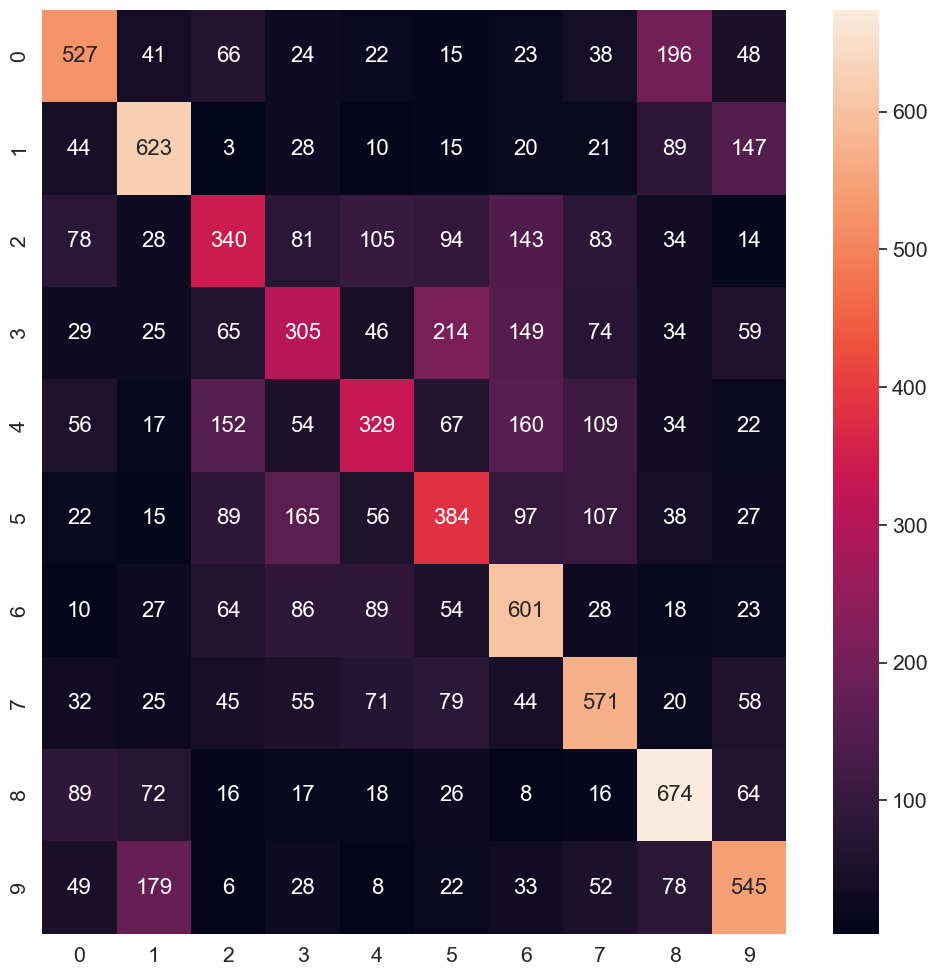

In [33]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d')

# Testando em exemplos próprios

In [34]:
from PIL import Image

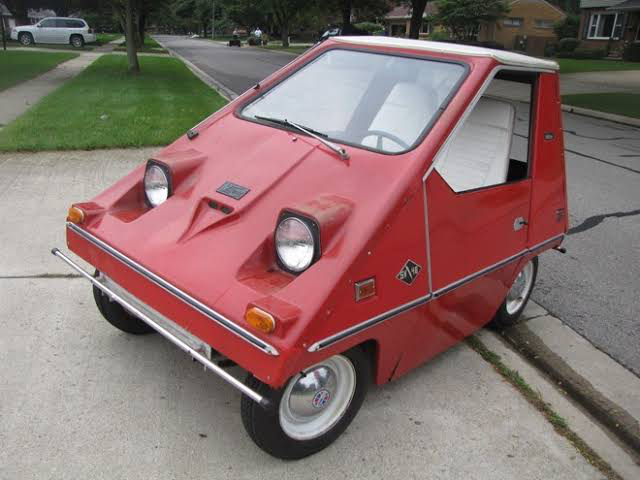

In [326]:
img = Image.open('fig/car5.jpg')
img

In [327]:
prep_transforms = T.Compose(
    [T.Resize((32, 32)),
     T.ToTensor(),
     T.Normalize( (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616) )
     ]
)
img_rgb = img.convert("RGB")
img_tensor = prep_transforms(img_rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5766771..1.6211325].


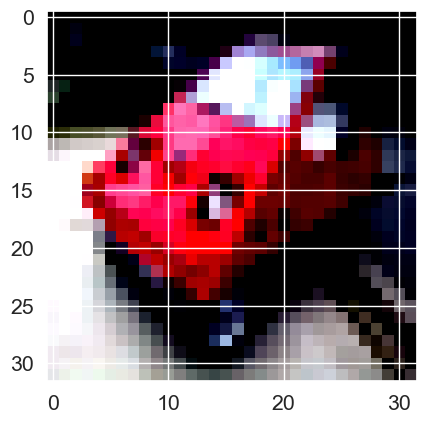

In [328]:
plt.imshow(img_tensor.permute(1,2, 0))

In [329]:
batch = img_tensor.unsqueeze(0).to(device)

In [330]:
convmodel.eval()

ConvolutionalModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [331]:
output = convmodel(batch)
output

tensor([[-1.5528,  1.4180, -0.5316,  0.5542,  1.3673,  1.4557,  0.5727,  1.8367,
         -2.2959,  1.2234]], grad_fn=<AddmmBackward0>)

In [332]:
logits = torch.nn.functional.softmax(output, dim=1) * 100
prob_dict = {}
for i, classname in enumerate(CATEGORIES):
  prob = logits[0][i].item()
  print(f"{classname} score: {prob:.2f}")
  prob_dict[classname] = [prob]

airplane score: 0.80
automobile score: 15.62
bird score: 2.22
cat score: 6.59
deer score: 14.85
dog score: 16.22
frog score: 6.71
horse score: 23.75
ship score: 0.38
truck score: 12.86


In [333]:
import pandas as pd

In [334]:
df_prob = pd.DataFrame.from_dict(prob_dict)

<Axes: >

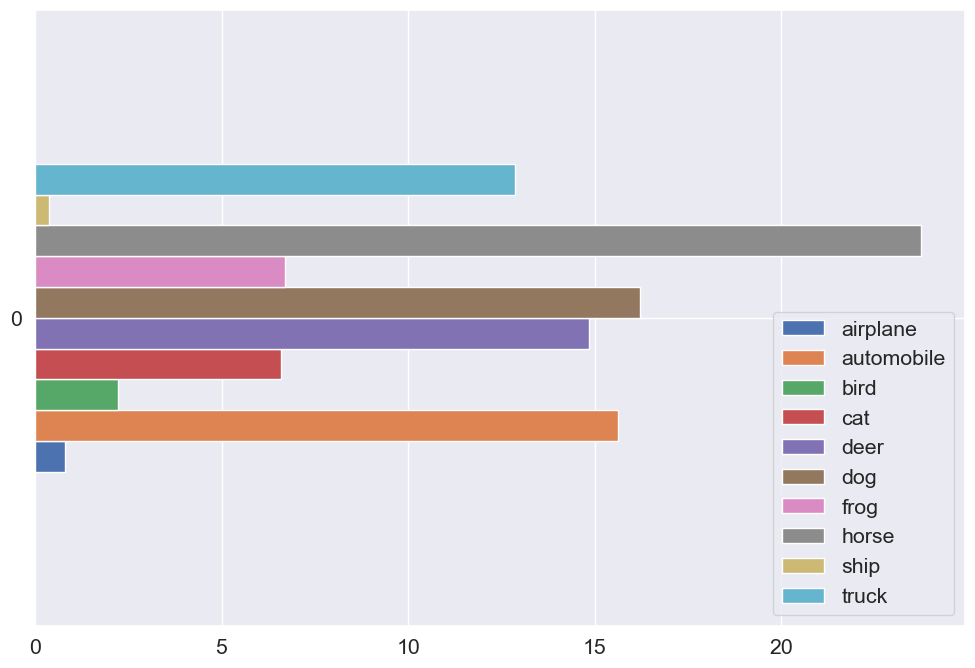

In [335]:
df_prob.plot(kind='barh', figsize=(12, 8))

# Salvando os modelos

In [336]:
torch.save(model.state_dict(), 'mlp_model_weights.pth')

In [337]:
torch.save(convmodel.state_dict(), 'conv_model_weights.pth')

# Referencias

GOODFELLOW, Ian; BENGIO, Yoshua; COURVILLE, Aaron. Deep Learning. Cambridge: MIT Press, 2016. Cap. 9, Convolutional Networks. Disponível em: https://www.deeplearningbook.org/contents/convnets.html.

 [Aprendendo múltiplas camadas de recursos a partir de pequenas imagens , Alex Krizhevsky, 2009.](https://www-cs-toronto-edu.translate.goog/~kriz/learning-features-2009-TR.pdf?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc)

 https://medium.com/data-hackers/como-funcionam-as-redes-neurais-convolucionais-cnns-71978185c1

https://github.com/pgdinamica/deeplearning/blob/main/notebooks/RedesConvolucionais.ipynb

https://www.youtube.com/live/doT7koXt9vw?si=m88NkhS2s3U15YXp

https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

https://www.deeplearningbook.org/contents/convnets.html

https://medium.com/ensina-ai/minha-primeira-convnet-66202f01da1a

https://medium.com/turing-talks/turing-talks-23-modelos-de-predi%C3%A7%C3%A3o-redes-neurais-convolucionais-d364654a34de